## **1. Import libraries**

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Get classes**

In [2]:
train_dir = 'train'
test_dir = 'test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

## **3. Create PyTorch DataLoader**

In [3]:
test_img_path = 'train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [4]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label


In [5]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, 
                           label2idx, split='train')
train_loader =  torch.utils.data.DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True, pin_memory=True)

val_dataset = ImageDataset(train_dir, True,
                          label2idx, split='val')
val_loader = torch.utils.data.DataLoader(val_dataset,
                       batch_size=batch_size,
                       shuffle=False, pin_memory=True)

test_dataset = ImageDataset(test_dir, True,
                           label2idx, split='test')
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


In [6]:
print(len(train_loader))  # Check number of batches in training DataLoader
print(len(val_loader))    # Check number of batches in validation DataLoader


90
23


## **4. Build MLP network**

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)




In [8]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

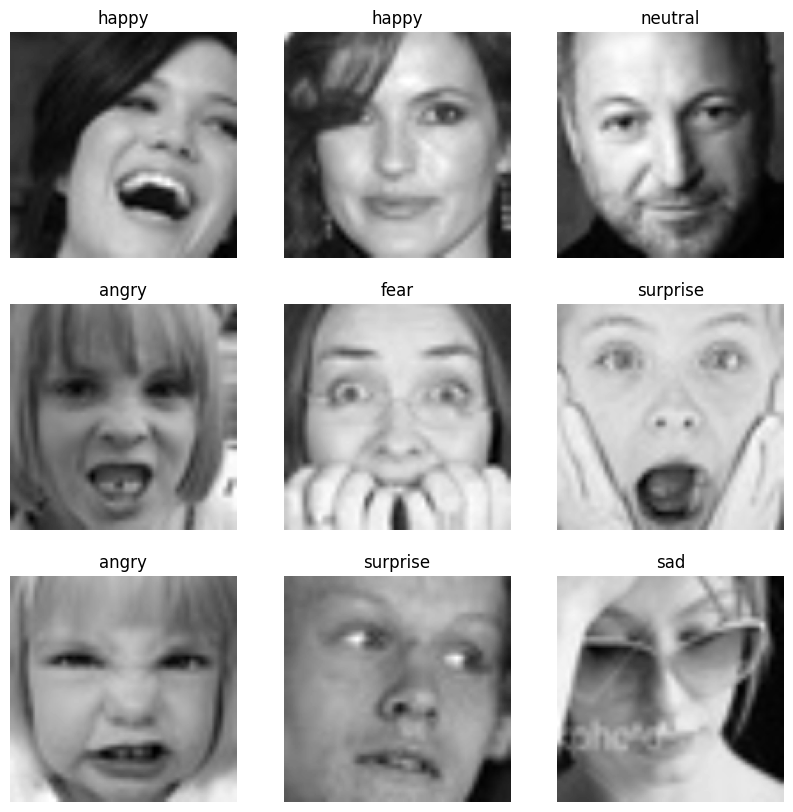

In [9]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")

    # Convert label to integer
    label = int(label_batch[i].item())  # Convert to integer

    # Get the corresponding label from idx2label
    if label in idx2label:
        plt.title(idx2label[label])
    else:
        plt.title("Unknown")  # Handle missing labels

    plt.axis("off")


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **5. Training**

In [11]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


In [12]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [13]:
# Verify model on GPU
print(f"Model device: {next(model.parameters()).device}")

# Verify data on GPU
for X_samples, y_samples in train_loader:
    X_samples = X_samples.to(device)
    y_samples = y_samples.to(device)
    print(f"Data devices: {X_samples.device}, {y_samples.device}")
    break


Model device: cuda:0
Data devices: cuda:0, cuda:0


In [14]:
for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}")  # Check if the epoch starts
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    
    for X_samples, y_samples in train_loader:
        # Move inputs and labels to GPU
        X_samples = X_samples.to(device, non_blocking=True)
        y_samples = y_samples.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.append(outputs.detach())
        train_target.append(y_samples)
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            # Move inputs and labels to GPU
            X_samples = X_samples.to(device, non_blocking=True)
            y_samples = y_samples.to(device, non_blocking=True)
            
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs)
            val_target.append(y_samples)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)
    
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


Starting epoch 1

EPOCH 1:	Training loss: 1.911	Validation loss: 1.869
Starting epoch 2

EPOCH 2:	Training loss: 1.843	Validation loss: 1.827
Starting epoch 3

EPOCH 3:	Training loss: 1.809	Validation loss: 1.802
Starting epoch 4

EPOCH 4:	Training loss: 1.787	Validation loss: 1.782
Starting epoch 5

EPOCH 5:	Training loss: 1.768	Validation loss: 1.765
Starting epoch 6

EPOCH 6:	Training loss: 1.750	Validation loss: 1.746
Starting epoch 7

EPOCH 7:	Training loss: 1.730	Validation loss: 1.726
Starting epoch 8

EPOCH 8:	Training loss: 1.709	Validation loss: 1.707
Starting epoch 9

EPOCH 9:	Training loss: 1.689	Validation loss: 1.690
Starting epoch 10

EPOCH 10:	Training loss: 1.672	Validation loss: 1.675
Starting epoch 11

EPOCH 11:	Training loss: 1.658	Validation loss: 1.666
Starting epoch 12

EPOCH 12:	Training loss: 1.647	Validation loss: 1.654
Starting epoch 13

EPOCH 13:	Training loss: 1.635	Validation loss: 1.647
Starting epoch 14

EPOCH 14:	Training loss: 1.625	Validation loss: 1.

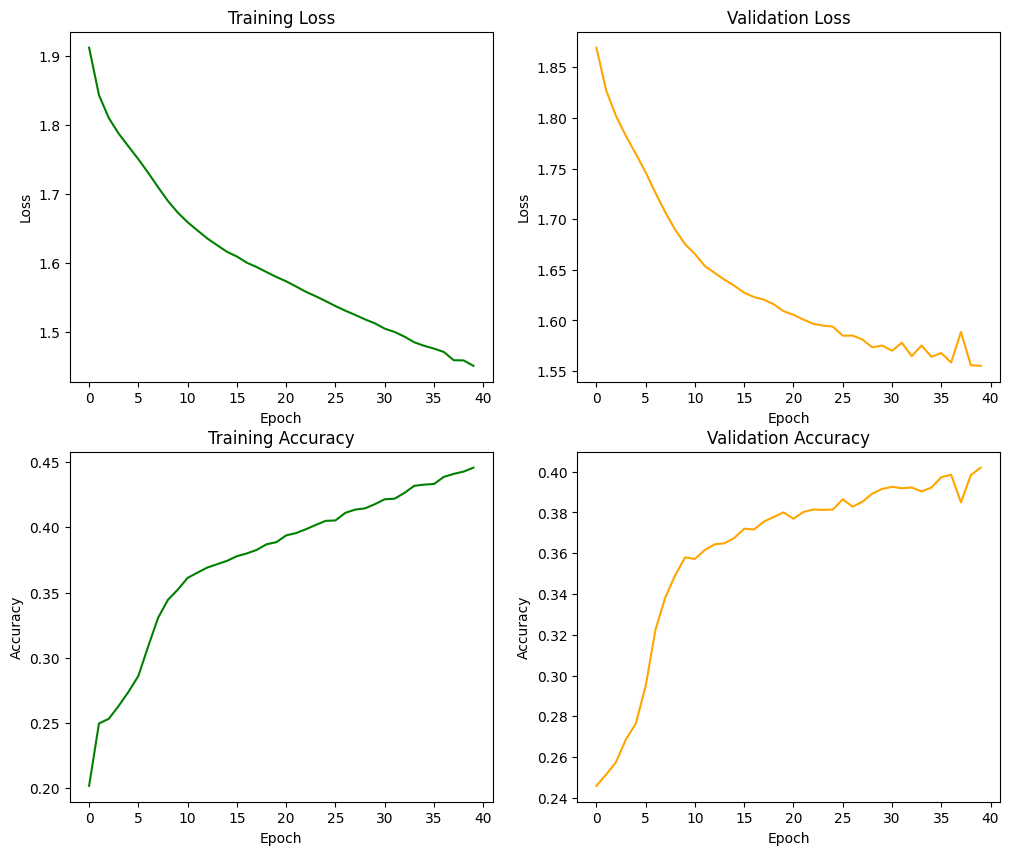

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Evaluation**

In [16]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.40195053988157436


In [17]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    val_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {val_acc}')

Evaluation on test set:
Accuracy: 0.4137642797436612
